##**Menyambungkan ke Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Import Package**

In [2]:
import random
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image

##**Exploratory Data Analysis**

In [3]:
# Path ke folder dataset
original_dir = '/content/drive/MyDrive/Natural Hand Digit'

# Fungsi untuk menghitung total gambar di setiap folder
def count_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):  # os.walk untuk mengiterasi semua subfolder
        image_count = len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))])  # Hitung file gambar
        if image_count > 0:
            print(f"Jumlah gambar di folder '{root}': {image_count}")  # Cetak jumlah gambar per folder
        total_images += image_count
    return total_images

# Hitung jumlah total gambar
total = count_images(original_dir)
print(f"Total gambar dalam folder '{original_dir}': {total}")

Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 5 1m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 2 50cm': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 3 1m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 4 1m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 4 50cm': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 5 50cm': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 3 50cm': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 3 2m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 4 2m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 5 2m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/Digit 1 2m': 330
Jumlah gambar di folder '/content/drive/MyDrive/Natural Hand Digit/D

Contoh Gambar dari Dataset:
Contoh gambar untuk Digit 1 1m:


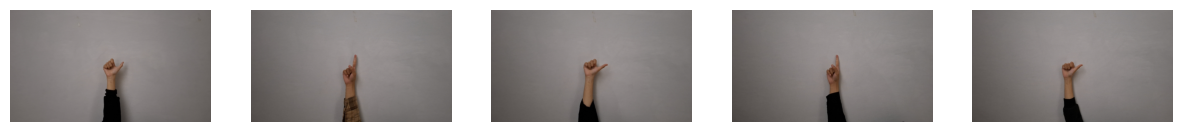

Contoh gambar untuk Digit 1 2m:


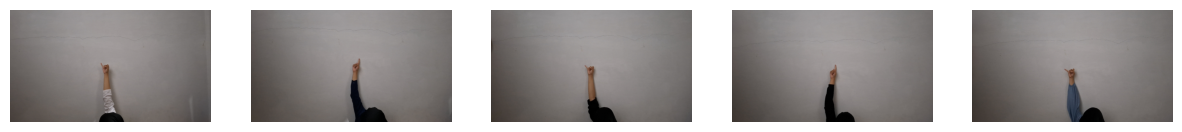

Contoh gambar untuk Digit 1 50cm:


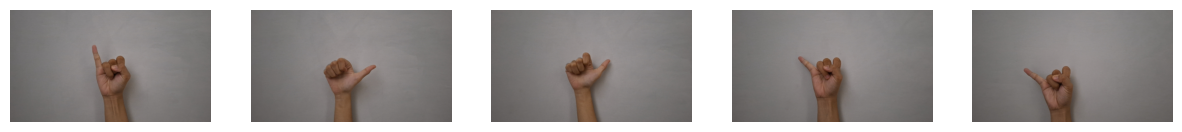

Contoh gambar untuk Digit 2 1m:


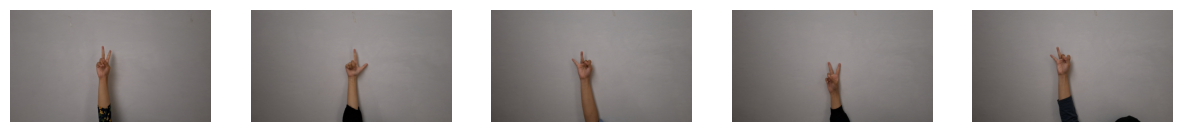

Contoh gambar untuk Digit 2 2m:


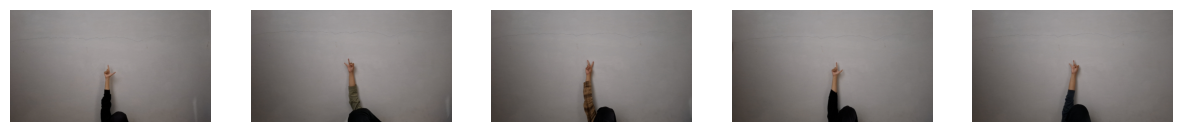

Contoh gambar untuk Digit 2 50cm:


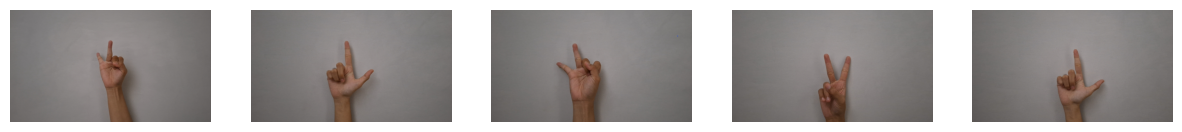

Contoh gambar untuk Digit 3 1m:


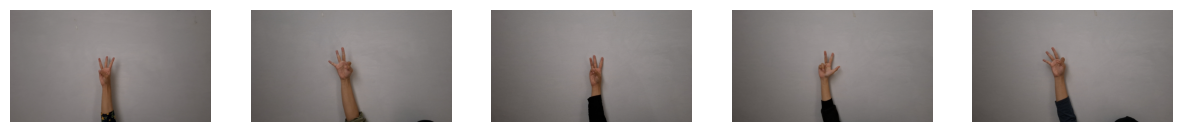

Contoh gambar untuk Digit 3 2m:


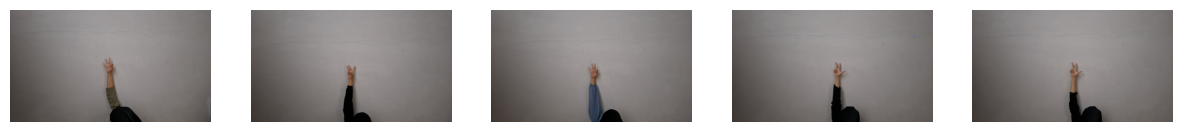

Contoh gambar untuk Digit 3 50cm:


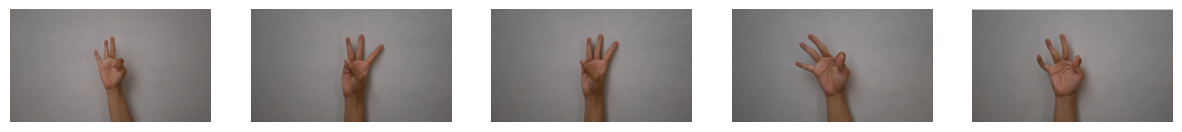

Contoh gambar untuk Digit 4 1m:


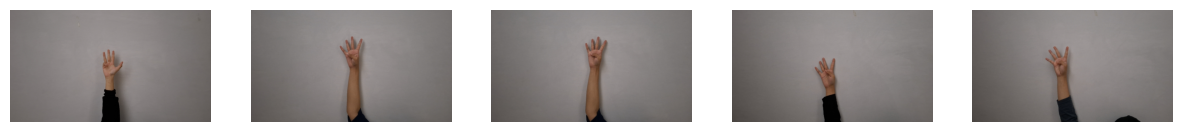

Contoh gambar untuk Digit 4 2m:


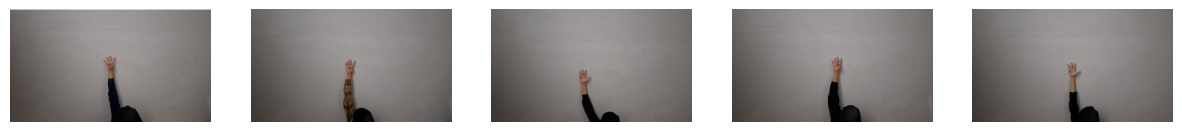

Contoh gambar untuk Digit 4 50cm:


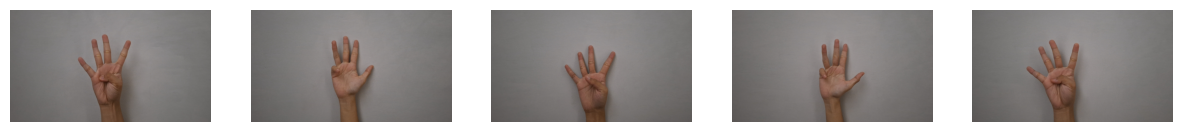

Contoh gambar untuk Digit 5 1m:


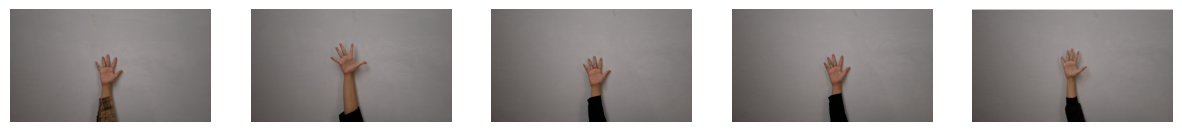

Contoh gambar untuk Digit 5 2m:


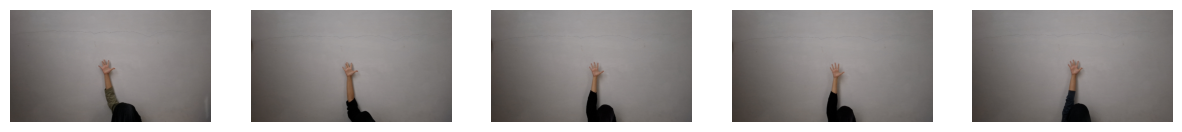

Contoh gambar untuk Digit 5 50cm:


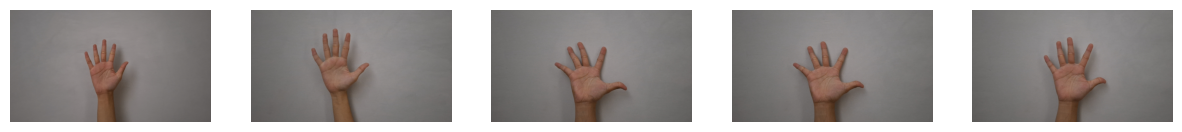

In [4]:
# Fungsi untuk menampilkan gambar sampel per folder (kelas)
def display_sample_images(directory, num_samples=5):
    class_names = sorted(os.listdir(directory))  # Menyortir nama kelas
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Memastikan itu adalah folder
            all_files = [file for file in os.listdir(class_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Hanya gambar
            if len(all_files) > 0:  # Memastikan ada gambar di folder
                sample_files = sorted(random.sample(all_files, min(num_samples, len(all_files))))  # Ambil sampel gambar
                print(f"Contoh gambar untuk {class_name}:")
                plt.figure(figsize=(15, 5))
                for i, file in enumerate(sample_files):
                    img_path = os.path.join(class_path, file)
                    img = mpimg.imread(img_path)
                    plt.subplot(1, num_samples, i + 1)  # Menampilkan dalam satu baris
                    plt.imshow(img)
                    plt.axis('off')  # Menonaktifkan axis untuk gambar
                plt.show()  # Menampilkan gambar dalam satu plot

# Path ke folder dataset
original_dir = '/content/drive/MyDrive/Natural Hand Digit'

# Tampilkan contoh gambar dari data train
print("Contoh Gambar dari Dataset:")
display_sample_images(original_dir)

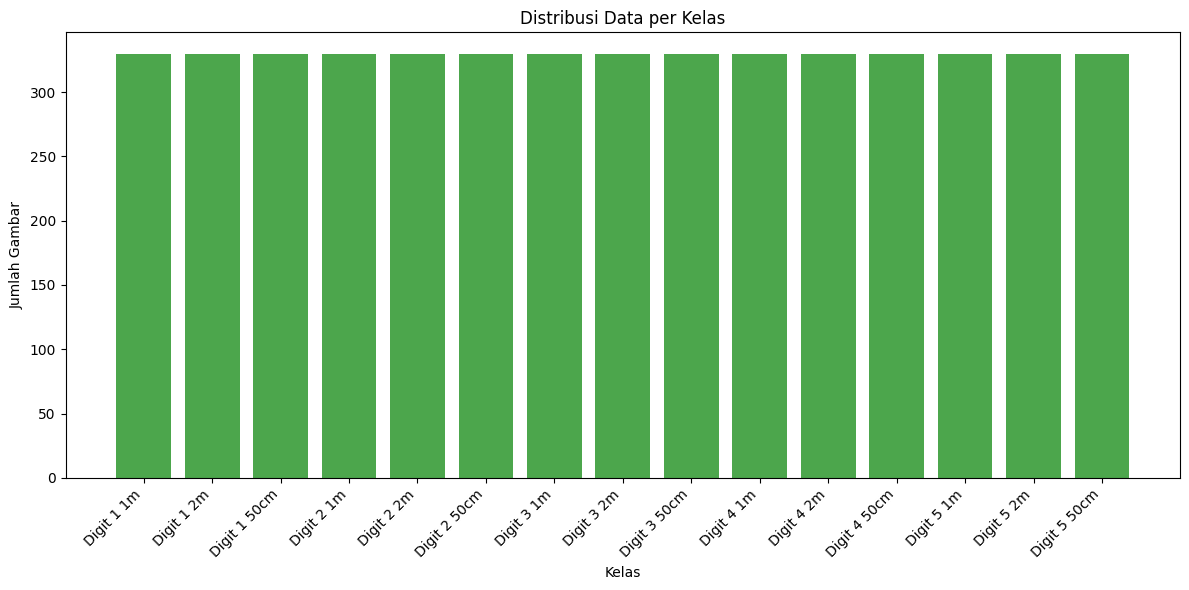

In [5]:
def plot_data_distribution(original_dir):
    # Menghitung jumlah gambar per kelas di seluruh data
    class_counts = {class_name: len(os.listdir(os.path.join(original_dir, class_name)))
                    for class_name in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, class_name))}

    # Ambil nama kelas dan jumlah gambar
    class_names = sorted(class_counts.keys())
    counts = [class_counts[class_name] for class_name in class_names]

    # Plot distribusi data
    x = range(len(class_names))  # Indeks untuk x-axis
    plt.figure(figsize=(12, 6))
    plt.bar(x, counts, color='green', alpha=0.7)

    # Tambahkan label dan judul
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title('Distribusi Data per Kelas')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.tight_layout()

    # Tampilkan plot
    plt.show()

# Panggil fungsi untuk visualisasi distribusi data
plot_data_distribution(original_dir)

##**Pre-Processing**

In [6]:
# Path direktori dataset asli dan target
original_dir = '/content/drive/MyDrive/Natural Hand Digit'
output_dir = '/content/drive/MyDrive/Processed Hand Digit'

# Rasio pembagian data
train_ratio = 0.8  # 80% untuk train
test_ratio = 0.2   # 20% untuk test

# Folder output untuk train dan test
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Hapus folder train dan test jika sudah ada, untuk menghindari duplikasi file
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Buat folder train dan test yang kosong
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Fungsi untuk membagi data
def split_data(original_dir, train_dir, test_dir, train_ratio):
    for subfolder in os.listdir(original_dir):
        if not os.path.isdir(os.path.join(original_dir, subfolder)):
            continue  # Skip non-folder items

        # Ekstrak nama kelas (misal, dari 'Digit 1 (1m)' ambil 'Digit 1')
        class_name = subfolder.split('(')[0].strip()

        # Path ke folder setiap subkelas
        class_dir = os.path.join(original_dir, subfolder)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        # Buat folder kelas di train dan test
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # List semua file dalam subfolder ini
        all_files = os.listdir(class_dir)
        random.shuffle(all_files)  # Acak file

        # Tentukan jumlah data untuk train dan test
        total_files = len(all_files)
        train_count = int(total_files * train_ratio)

        # Pindahkan file ke masing-masing folder
        for idx, file in enumerate(all_files):
            file_path = os.path.join(class_dir, file)
            if idx < train_count:
                shutil.copy(file_path, os.path.join(train_class_dir, file))
            else:
                shutil.copy(file_path, os.path.join(test_class_dir, file))

# Jalankan pembagian data
split_data(original_dir, train_dir, test_dir, train_ratio)

print("Dataset berhasil dibagi ke dalam train dan test.")

Dataset berhasil dibagi ke dalam train dan test.


In [7]:
# Fungsi untuk menghitung total gambar, proporsi, dan distribusi kelas
def analyze_dataset(train_dir, test_dir):
    # Inisialisasi variabel
    total_train_images = 0
    total_test_images = 0
    train_class_distribution = {}
    test_class_distribution = {}

    # Hitung distribusi kelas di train
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            class_images = os.listdir(class_path)
            train_class_distribution[class_name] = len(class_images)
            total_train_images += len(class_images)

    # Hitung distribusi kelas di test
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            class_images = os.listdir(class_path)
            test_class_distribution[class_name] = len(class_images)
            total_test_images += len(class_images)

    # Total gambar
    total_images = total_train_images + total_test_images

    # Proporsi data train dan test
    train_ratio = total_train_images / total_images if total_images > 0 else 0
    test_ratio = total_test_images / total_images if total_images > 0 else 0

    # Tampilkan hasil
    print("Total Gambar:")
    print(f"- Total: {total_images}")
    print(f"- Train: {total_train_images}")
    print(f"- Test: {total_test_images}\n")

    print("Proporsi Data:")
    print(f"- Train: {train_ratio:.2%}")
    print(f"- Test: {test_ratio:.2%}\n")

    print("Distribusi Kelas di Train:")
    for class_name, count in train_class_distribution.items():
        print(f"- {class_name}: {count} gambar")

    print("\nDistribusi Kelas di Test:")
    for class_name, count in test_class_distribution.items():
        print(f"- {class_name}: {count} gambar")

# Jalankan analisis dataset
analyze_dataset(train_dir, test_dir)

Total Gambar:
- Total: 4950
- Train: 3960
- Test: 990

Proporsi Data:
- Train: 80.00%
- Test: 20.00%

Distribusi Kelas di Train:
- Digit 5 1m: 264 gambar
- Digit 2 50cm: 264 gambar
- Digit 3 1m: 264 gambar
- Digit 4 1m: 264 gambar
- Digit 4 50cm: 264 gambar
- Digit 5 50cm: 264 gambar
- Digit 3 50cm: 264 gambar
- Digit 3 2m: 264 gambar
- Digit 4 2m: 264 gambar
- Digit 5 2m: 264 gambar
- Digit 1 2m: 264 gambar
- Digit 2 2m: 264 gambar
- Digit 2 1m: 264 gambar
- Digit 1 50cm: 264 gambar
- Digit 1 1m: 264 gambar

Distribusi Kelas di Test:
- Digit 5 1m: 66 gambar
- Digit 2 50cm: 66 gambar
- Digit 3 1m: 66 gambar
- Digit 4 1m: 66 gambar
- Digit 4 50cm: 66 gambar
- Digit 5 50cm: 66 gambar
- Digit 3 50cm: 66 gambar
- Digit 3 2m: 66 gambar
- Digit 4 2m: 66 gambar
- Digit 5 2m: 66 gambar
- Digit 1 2m: 66 gambar
- Digit 2 2m: 66 gambar
- Digit 2 1m: 66 gambar
- Digit 1 50cm: 66 gambar
- Digit 1 1m: 66 gambar


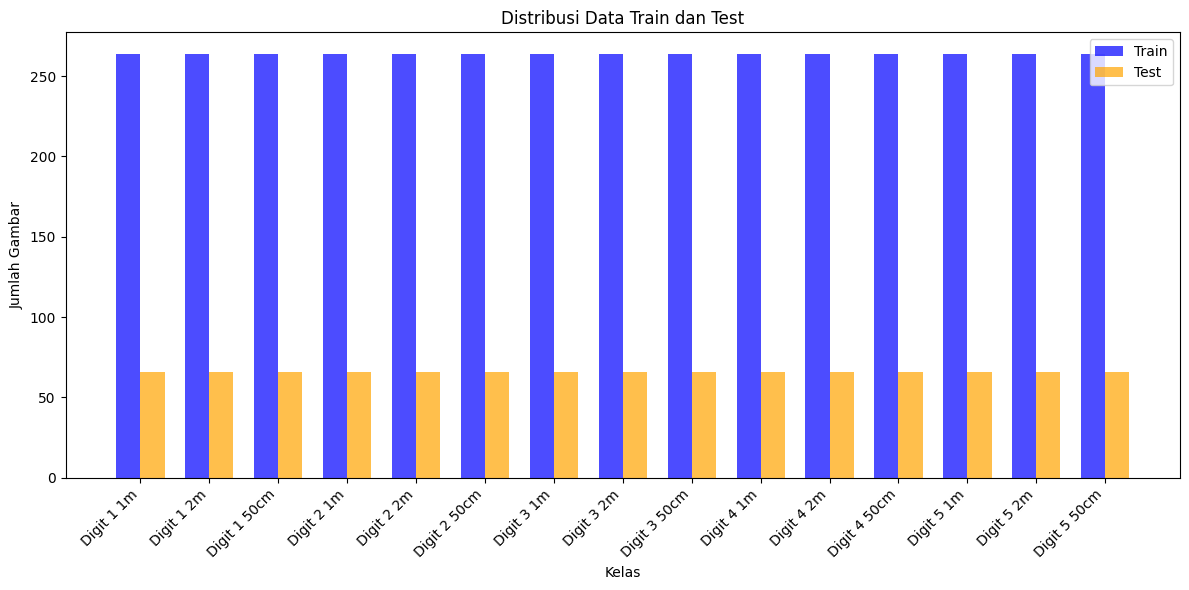

In [8]:
def plot_data_distribution(train_dir, test_dir):
    # Menghitung jumlah gambar per kelas di train dan test
    train_class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name)))
                          for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))}

    test_class_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name)))
                         for class_name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, class_name))}

    # Gabungkan data train dan test untuk plot
    class_names = sorted(set(train_class_counts.keys()).union(test_class_counts.keys()))
    train_counts = [train_class_counts.get(class_name, 0) for class_name in class_names]
    test_counts = [test_class_counts.get(class_name, 0) for class_name in class_names]

    # Plot distribusi data
    x = range(len(class_names))  # Indeks untuk x-axis
    width = 0.35  # Lebar bar

    plt.figure(figsize=(12, 6))
    plt.bar(x, train_counts, width, label='Train', color='blue', alpha=0.7)
    plt.bar([i + width for i in x], test_counts, width, label='Test', color='orange', alpha=0.7)

    # Tambahkan label dan judul
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.title('Distribusi Data Train dan Test')
    plt.xticks([i + width / 2 for i in x], class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Tampilkan plot
    plt.show()

# Panggil fungsi untuk visualisasi distribusi data
plot_data_distribution(train_dir, test_dir)

##**Pembuatan Model**

In [9]:
# Definisikan model CNN sederhana
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

##**Training Model**

In [10]:
# Tentukan parameter model
input_shape = (224, 224, 3)  # Sesuaikan ukuran input gambar
batch_size = 32
epochs = 10  # Sesuaikan dengan kebutuhan
num_classes = len(os.listdir(train_dir))  # Jumlah kelas berdasarkan folder di train_dir

# Inisialisasi data generator untuk augmentasi data dan normalisasi
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load data train dan test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Buat model dan latih dengan data train
model = create_model(input_shape, num_classes)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Found 3960 images belonging to 15 classes.
Found 990 images belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 94s 662ms/step - accuracy: 0.1114 - loss: 2.6994 - val_accuracy: 0.3838 - val_loss: 1.5510
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 124s 581ms/step - accuracy: 0.3366 - loss: 1.6831 - val_accuracy: 0.4364 - val_loss: 1.3008
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 74s 508ms/step - accuracy: 0.4361 - loss: 1.3522 - val_accuracy: 0.5030 - val_loss: 1.1054
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 80s 499ms/step - accuracy: 0.5005 - loss: 1.1616 - val_accuracy: 0.7182 - val_loss: 0.7497
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 83s 518ms/step - accuracy: 0.5975 - loss: 0.9057 - val_accuracy: 0.7515 - val_loss: 0.6349
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 87s 565ms/step - accuracy: 0.6247 - loss: 0.8601 - val_accuracy: 0.7515 - val_loss: 0.6208
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 77s 521ms/step - accuracy: 0.6540 - loss: 0.7624 - val_accuracy: 0.7677 - val_loss: 0.5359
Epoch 8/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 65s 497ms/step - accuracy: 0.7135 - loss: 0.6547 - va

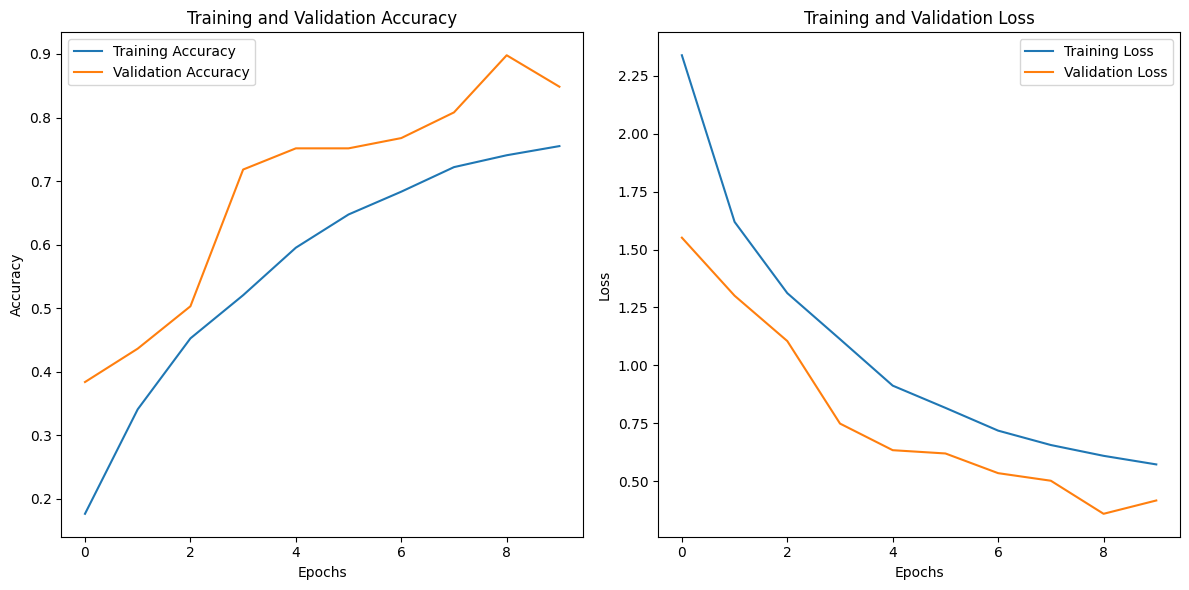

In [11]:
# Plot akurasi dan loss selama training
def plot_training_history(history):
    # Akurasi
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [12]:
# Evaluasi model pada data uji dan hitung tingkat kesalahan klasifikasi
def evaluate_model(test_generator, model):
    # Reset generator untuk memastikan data tidak teracak
    test_generator.reset()

    # Evaluasi model menggunakan generator
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    # Hitung misclassification rate
    miss_class_rate = 1 - test_acc
    print(f"Misclassification Rate: {miss_class_rate:.4f}")

# Generate laporan klasifikasi per folder
def generate_classification_report(data_dir, model, class_indices):
    # Mapping index ke nama kelas
    index_to_class = {v: k for k, v in class_indices.items()}

    y_true = []
    y_pred = []

    # Loop untuk setiap folder kelas
    for class_folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, class_folder)

        # Lewati jika bukan folder
        if not os.path.isdir(folder_path):
            continue

        # Label yang benar berdasarkan nama folder
        true_label = class_folder

        # Loop untuk setiap gambar di folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            img = load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran jika diperlukan
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Menambahkan batch dimensi
            img_array /= 255.0  # Normalisasi sama seperti data generator

            # Prediksi menggunakan model
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # Convert indeks prediksi ke nama kelas
            predicted_class_name = index_to_class[predicted_class]

            # Tambahkan label benar dan prediksi
            y_true.append(true_label)
            y_pred.append(predicted_class_name)

    # Generate laporan klasifikasi
    report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()), digits=2)
    print(report)

# Evaluasi model pada test set
evaluate_model(test_generator, model)

# Generate laporan klasifikasi per folder
generate_classification_report(test_dir, model, train_generator.class_indices)

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.8257 - loss: 0.4391
Test Loss: 0.4182
Test Accuracy: 0.8485
Misclassification Rate: 0.1515
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 425ms/step


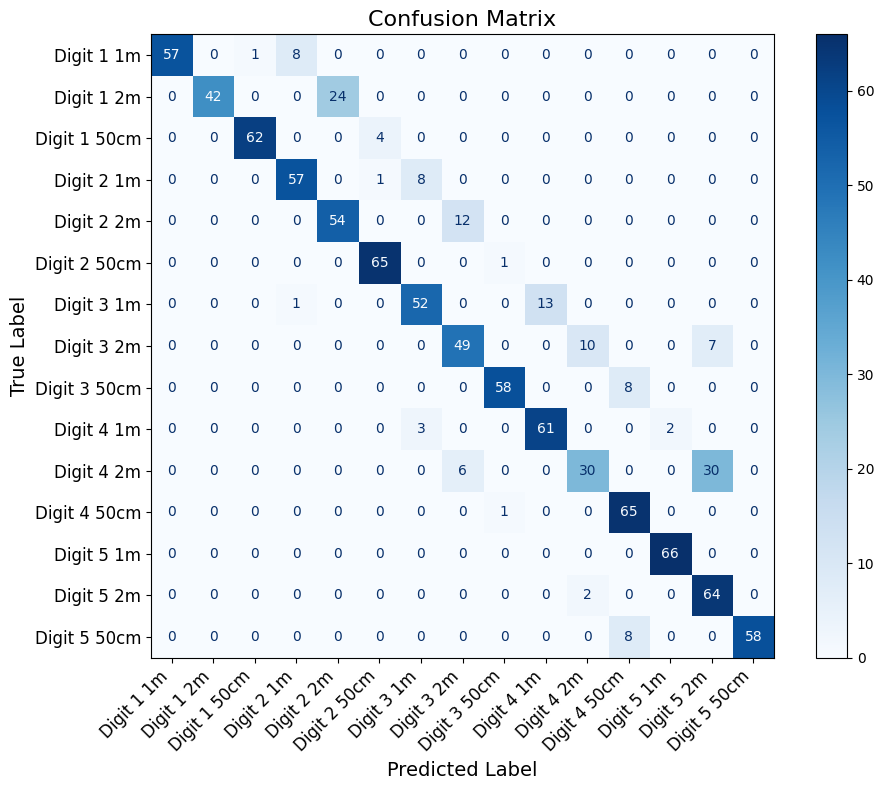

In [13]:
# Prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi ke kelas

# Ambil label sebenarnya
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())  # Nama kelas

# Tampilkan confusion matrix dengan visualisasi yang lebih baik
fig, ax = plt.subplots(figsize=(10, 8))  # Atur ukuran grafik
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

# Penyesuaian tambahan untuk visualisasi
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotasi label sumbu x
plt.yticks(fontsize=12)  # Ukuran label sumbu y
plt.tight_layout()  # Hindari teks bertumpuk

# Tampilkan plot
plt.show()